In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
coord = (20.665312,-103.403223)

df_coord = pd.DataFrame(columns=['lat','long'])
df_coord.loc[0] = coord[0],coord[1]
gdf = gpd.GeoDataFrame(
    df_coord, geometry=gpd.points_from_xy(df_coord.long, df_coord.lat))

In [3]:
schema = 'hexgrid'
hex_folder = 'hexgrid_8_city'

point_wkt = gdf.geometry.to_wkt()[0]
query = f"SELECT * FROM {schema}.{hex_folder} WHERE ST_Intersects(geometry, 'SRID=4326;{point_wkt}')"

In [4]:
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
hex_gdf

,geometry,hex_id_8,CVEGEO,metropolis
0,"POLYGON ((-103.40441 20.65818, -103.39987 20.6...",88498c96d9fffff,14120,Guadalajara


<AxesSubplot:>

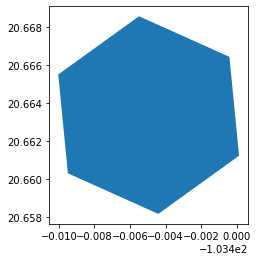

In [5]:
hex_gdf.plot()

In [6]:
# Reads mun_gdf GeoDataFrame as polygon
poly = hex_gdf.geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

In [7]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

In [8]:
time_of_interest = "2020-01-01/2020-06-30"

In [9]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 23 Items


In [10]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [15]:
assets_hrefs = {}

for i in items:
    assets_hrefs[i.datetime.date()] = [pc.sign(find_asset_by_band_common_name(i,"red").href)]
    assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"green").href))
    assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"blue").href))
    assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"nir").href))

In [16]:
i = 0
for k in assets_hrefs.keys():
    if i == 0:
        assets_hrefs_filter = assets_hrefs[k]
    i += 1

In [17]:
def raster_to_point(href, gdf, rescale=False):
    
    with rasterio.open(href) as ds:

        gdf_tmp = gdf.copy()
        gdf_tmp = gdf_tmp.to_crs("EPSG:"+str(ds.crs.to_epsg()))
        gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
        poly_mask = gdf_tmp.dissolve().geometry

        out_mask, out_transform = rasterio.mask.mask(ds, poly_mask, crop=True)
        out_meta = ds.meta
        
        ds.close()

    out_meta.update({"driver": "GTiff",
                     "height": out_mask.shape[1],
                     "width": out_mask.shape[2],
                     "transform": out_transform})

    with rasterio.open("tmp/masked.tif", "w", **out_meta) as dest:
        dest.write(out_mask)
        
        dest.close()

    with rasterio.open("tmp/masked.tif", "r", **out_meta) as src:

        val = src.read(1)
        no_data=src.nodata
        geometry = [Point(src.xy(x,y)[0],src.xy(x,y)[1]) 
                    for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
        v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
        gdf = gpd.GeoDataFrame({'geometry':geometry,'data':v})
        gdf.crs = src.crs
        
        src.close()
        
    return gdf

In [18]:
ndvi_dict = {}

g = raster_to_point(assets_hrefs_filter[1], hex_gdf) # green band
nir = raster_to_point(assets_hrefs_filter[3], hex_gdf) # near-infrared band
ndvi_gdf = g.merge(nir[['data']], left_index=True, right_index=True)
ndvi_gdf.rename(columns={'data_x':'g','data_y':'nir'}, inplace=True)
ndvi_gdf['ndvi'] = (ndvi_gdf['nir']-ndvi_gdf['g'])/(ndvi_gdf['nir']+ndvi_gdf['g'])
ndvi_gdf = ndvi_gdf.to_crs("EPSG:4326")

<AxesSubplot:>

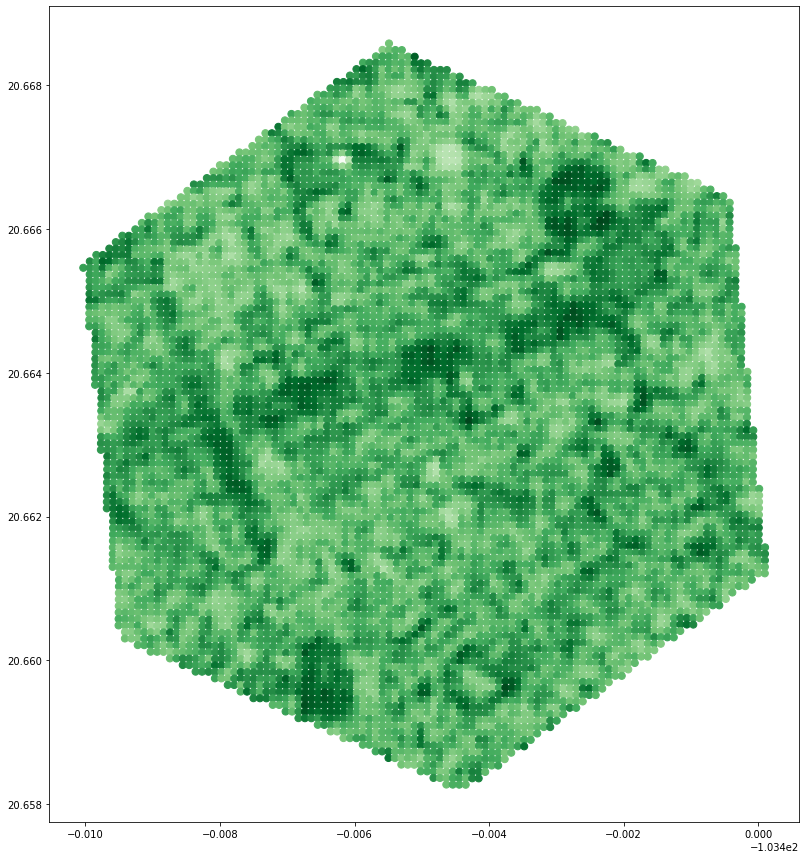

In [20]:
fig,ax = plt.subplots(figsize=(15,15))
ndvi_gdf.plot('ndvi', markersize=50, ax=ax, cmap='Greens')

In [47]:
rbg_refs = [asset_href for asset_href in assets_hrefs_filter[:3]]

In [48]:


def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)


bands = [read_band(href) for href in rbg_refs]


In [49]:
multiband_data = np.stack(bands)

In [50]:
rescaled = multiband_data.astype(float)
min_value, max_value = rescaled.min(), rescaled.max()
rescaled = ((rescaled - min_value) * 255) / (max_value - min_value)
byte_data = rescaled.astype("ubyte")

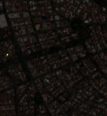

In [55]:
Image.fromarray(np.transpose(byte_data, axes=[1, 2, 0]))


In [53]:
np.transpose(byte_data, axes=[1, 2, 0]).shape

(116, 107, 3)

## Hex index

In [61]:
grl_dir = '/workspaces/accesibilidad-urbana/data/raw/pixel_image/'
df = pd.read_csv(grl_dir + 'ubicaciones_hexagonos.csv', encoding='latin-1')
print(df.shape)
df.head(2)

(8, 8)


,Ciudad,hex_1,hex_2,hex_3,hex_4,hex_5,hex_6,hex_7
0,Santa Tere,89498c96843ffff,NaN,NaN,NaN,NaN,NaN,NaN
1,Chapalita,89498c96d83ffff,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
city_dict = {}
for i in range(len(df)):
    city_array = np.array(df.iloc[i])
    city = city_array[0]
    hex_idx = city_array[1:]
    hex_idx_list = []
    for idx in hex_idx:
        if idx is not np.nan:
            hex_idx_list.append(idx)
            
    city_dict[city] = hex_idx_list

In [77]:
city_dict.keys()

dict_keys(['Santa Tere', 'Chapalita', 'Mesa Colorada', 'Lomas del Cuatro ', 'Valle Real', 'Centro histórico GDL ', 'Centro histórico MTY', 'Centro histórico CDMX'])

In [80]:
schema = 'hexgrid'
hex_folder = 'hexgrid_9_city'

query = f"SELECT * FROM {schema}.{hex_folder} WHERE hex_id_9 IN {str(tuple(city_dict['Centro histórico GDL ']))}"

In [81]:
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
hex_gdf

,geometry,hex_id_9,CVEGEO,metropolis
0,"POLYGON ((-103.34379 20.68237, -103.34501 20.6...",89498c945afffff,14039,Guadalajara
1,"POLYGON ((-103.34447 20.67556, -103.34535 20.6...",89498c945b7ffff,14039,Guadalajara
2,"POLYGON ((-103.34379 20.68237, -103.34467 20.6...",89498c96adbffff,14039,Guadalajara
3,"POLYGON ((-103.34447 20.67556, -103.34238 20.6...",89498c945a3ffff,14039,Guadalajara
4,"POLYGON ((-103.34745 20.67752, -103.34535 20.6...",89498c945a7ffff,14039,Guadalajara
5,"POLYGON ((-103.35009 20.68289, -103.35131 20.6...",89498c96ad3ffff,14039,Guadalajara
6,"POLYGON ((-103.34745 20.67752, -103.34833 20.6...",89498c96e6bffff,14039,Guadalajara


<AxesSubplot:>

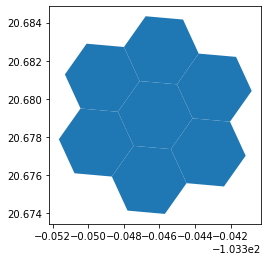

In [82]:
hex_gdf.plot()

In [84]:
# Reads mun_gdf GeoDataFrame as polygon
# hex_diss = hex_gdf.to_crs("EPSG:6372").buffer(1).dissolve().to_crs("EPSG:4326")
poly = hex_gdf.geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

In [85]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

In [86]:
time_of_interest = "2020-06-01/2020-06-30"

In [87]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


In [88]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [89]:
assets_hrefs = {}

for i in items:
    assets_hrefs[i.datetime.date()] = [pc.sign(find_asset_by_band_common_name(i,"red").href)]
    assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"green").href))
    assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"blue").href))
    assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"nir").href))

In [90]:
i = 0
for k in assets_hrefs.keys():
    if i == 0:
        assets_hrefs_filter = assets_hrefs[k]
    i += 1

In [91]:
def raster_to_point(href, gdf, rescale=False):
    
    with rasterio.open(href) as ds:

        gdf_tmp = gdf.copy()
        gdf_tmp = gdf_tmp.to_crs("EPSG:"+str(ds.crs.to_epsg()))
        gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
        poly_mask = gdf_tmp.dissolve().geometry

        out_mask, out_transform = rasterio.mask.mask(ds, poly_mask, crop=True)
        out_meta = ds.meta
        
        ds.close()

    out_meta.update({"driver": "GTiff",
                     "height": out_mask.shape[1],
                     "width": out_mask.shape[2],
                     "transform": out_transform})

    with rasterio.open("tmp/masked.tif", "w", **out_meta) as dest:
        dest.write(out_mask)
        
        dest.close()

    with rasterio.open("tmp/masked.tif", "r", **out_meta) as src:

        val = src.read(1)
        no_data=src.nodata
        geometry = [Point(src.xy(x,y)[0],src.xy(x,y)[1]) 
                    for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
        v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
        gdf = gpd.GeoDataFrame({'geometry':geometry,'data':v})
        gdf.crs = src.crs
        
        src.close()
        
    return gdf

In [92]:
ndvi_dict = {}

g = raster_to_point(assets_hrefs_filter[1], hex_gdf) # green band
nir = raster_to_point(assets_hrefs_filter[3], hex_gdf) # near-infrared band
ndvi_gdf = g.merge(nir[['data']], left_index=True, right_index=True)
ndvi_gdf.rename(columns={'data_x':'g','data_y':'nir'}, inplace=True)
ndvi_gdf['ndvi'] = (ndvi_gdf['nir']-ndvi_gdf['g'])/(ndvi_gdf['nir']+ndvi_gdf['g'])
ndvi_gdf = ndvi_gdf.to_crs("EPSG:4326")

<AxesSubplot:>

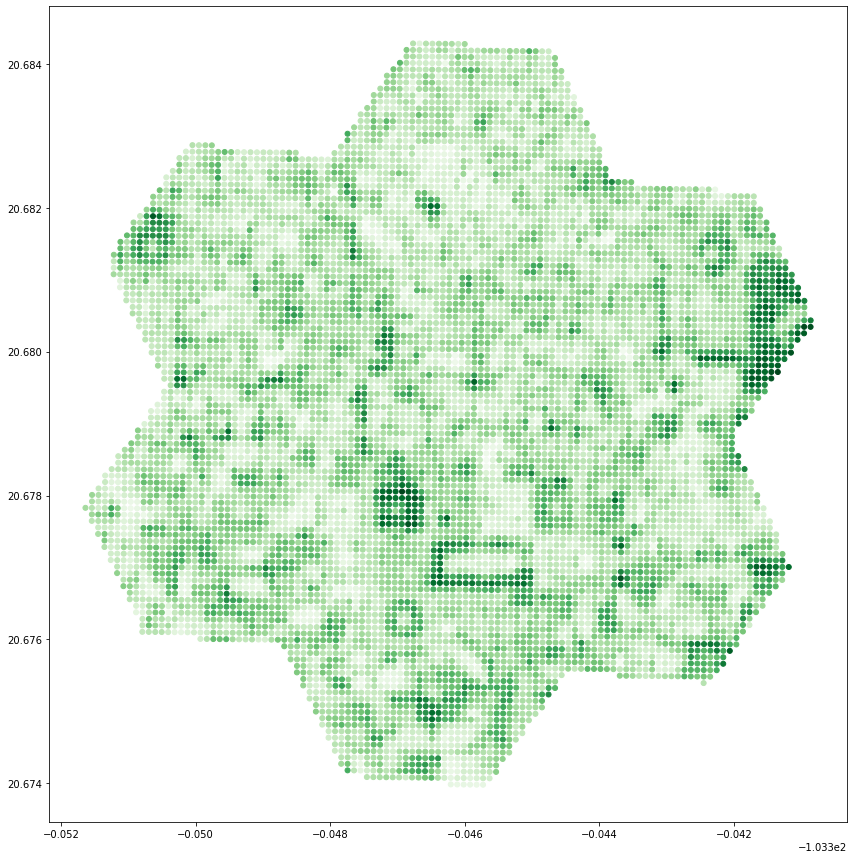

In [98]:
fig,ax = plt.subplots(figsize=(15,15))
ndvi_gdf.plot('ndvi', markersize=25, ax=ax, cmap='Greens')

#### pipeline

In [100]:
schema = 'hexgrid'
hex_folder = 'hexgrid_9_city'
grl_dir = '/workspaces/accesibilidad-urbana/data/processed/pixel_image/'


for k in city_dict.keys():
    
    if len(city_dict[k]) == 1:
        query = f"SELECT * FROM {schema}.{hex_folder} WHERE hex_id_9 IN ({city_dict[k][0]})"
    else:
        query = f"SELECT * FROM {schema}.{hex_folder} WHERE hex_id_9 IN {str(tuple(city_dict[k]))}"
    hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')

    # Reads mun_gdf GeoDataFrame as polygon
    # hex_diss = hex_gdf.to_crs("EPSG:6372").buffer(1).dissolve().to_crs("EPSG:4326")
    poly = hex_gdf.geometry
    # Extracts coordinates from polygon as DataFrame
    coord_val = poly.bounds
    # Gets coordinates for bounding box
    n = coord_val.maxy.max()
    s = coord_val.miny.min()
    e = coord_val.maxx.max()
    w = coord_val.minx.min()

    area_of_interest = {
        "type": "Polygon",
        "coordinates": [
            [
                [e, s],
                [w, s],
                [w, n],
                [e, n],
                [e, s],
            ]
        ],
    }

    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=area_of_interest,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": 10}},
    )

    # Check how many items were returned
    items = list(search.get_items())

    assets_hrefs = {}

    for i in items:
        assets_hrefs[i.datetime.date()] = [pc.sign(find_asset_by_band_common_name(i,"red").href)]
        assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"green").href))
        assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"blue").href))
        assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"nir").href))

    i = 0
    for k in assets_hrefs.keys():
        if i == 0:
            assets_hrefs_filter = assets_hrefs[k]
        i += 1

    g = raster_to_point(assets_hrefs_filter[1], hex_gdf) # green band
    nir = raster_to_point(assets_hrefs_filter[3], hex_gdf) # near-infrared band
    ndvi_gdf = g.merge(nir[['data']], left_index=True, right_index=True)
    ndvi_gdf.rename(columns={'data_x':'g','data_y':'nir'}, inplace=True)
    ndvi_gdf['ndvi'] = (ndvi_gdf['nir']-ndvi_gdf['g'])/(ndvi_gdf['nir']+ndvi_gdf['g'])
    ndvi_gdf = ndvi_gdf.to_crs("EPSG:4326")
    
    ndvi_gdf.to_file(grl_dir + f'{k}_ndvi.geojson', driver='GeoJSON')
    

    fig,ax = plt.subplots(figsize=(15,15))
    ndvi_gdf.plot('ndvi', markersize=25, ax=ax, cmap='Greens')
    
    plt.savefig(grl_dir+f'{k}_ndvi.svg')

ProgrammingError: (psycopg2.errors.SyntaxError) syntax error at or near "c96843ffff"
LINE 1: ...OM hexgrid.hexgrid_9_city WHERE hex_id_9 IN (89498c96843ffff...
                                                             ^

[SQL: SELECT * FROM hexgrid.hexgrid_9_city WHERE hex_id_9 IN (89498c96843ffff)]
(Background on this error at: https://sqlalche.me/e/14/f405)